In [1]:
import itertools
import matplotlib
from matplotlib.patches import Ellipse
from operator import itemgetter
from sklearn.decomposition import PCA
import sys
sys.path.append('/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods')
from settings import *
import helpers
%matplotlib inline
config_file = "/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/in-patient-transcription-state/config"
config_dict = helpers.process_config(config_file)

# Output
figures_dir = config_dict["out_dir"]["figures"]
results_dir = config_dict["out_dir"]["results"]

# Strain Info

strain_info = pd.read_csv(strain_info_file, index_col=0)
strains = config_dict["strains"]["all"].split()
over = config_dict['strains']['over'].split()
under = config_dict['strains']['under'].split()

b1 = config_dict['strains']['b1_strains'].split()
b2 = config_dict['strains']['b2_strains'].split()

# Counts/TPMs
counts_file = config_dict["data"]["core_tpms"]

/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods/helpers.py


In [2]:
strain_info

,STRAIN,MEDIA,PRED_PHYLO,HISTORY
HM01 | URINE,HM01,URINE,E,N
HM01 | PATIENT,HM01,PATIENT,E,N
HM03 | URINE,HM03,URINE,B1,N
HM03 | PATIENT,HM03,PATIENT,B1,N
HM06 | URINE,HM06,URINE,B2,N
HM06 | PATIENT,HM06,PATIENT,B2,N
HM07 | URINE,HM07,URINE,B1,Y
HM07 | PATIENT,HM07,PATIENT,B1,Y
HM14 | URINE,HM14,URINE,B1,Y
HM14 | PATIENT,HM14,PATIENT,B1,Y


In [2]:
counts = pd.read_csv(counts_file, index_col=0)
tpms = counts[[c for c in counts.columns if 'tpm' in c]]
tpms.columns = [c.split("_tpm")[0] for c in tpms.columns]
print(tpms.shape)
ntpms = tpms.apply(invnorm)
print(ntpms.head())

(2653, 28)
        HM01_UR  HM01_UTI   HM03_UR  HM03_UTI   HM06_UR  HM06_UTI   HM07_UR  \
b4182 -1.188012 -1.109430 -1.264135 -1.195702 -0.940124 -1.016354 -1.055125   
b1960 -0.925525 -0.168980 -0.704146 -0.215180 -0.677755 -0.485120 -0.516179   
b2866 -0.061452 -0.785192 -0.614878 -1.336750 -0.418148 -0.944542 -0.845802   
b0328 -0.032130 -1.430208 -0.264779 -0.979053 -0.962405 -0.620595 -0.096522   
b1660 -0.263800  0.533529  0.133617  0.796819  0.233590  0.693291  0.248180   

       HM07_UTI   HM14_UR  HM14_UTI    ...      HM57_UR  HM57_UTI   HM60_UR  \
b4182 -0.929156 -1.566525 -1.679256    ...    -0.963907 -0.238447 -1.221193   
b1960 -0.533529 -0.554343 -0.252079    ...    -0.899733  0.034493 -0.789056   
b2866 -1.073436 -0.542264 -1.419776    ...    -0.408886 -0.889863 -0.380288   
b0328 -1.205413 -0.220986 -0.977528    ...    -0.416087 -0.541170  0.410941   
b1660  0.537891  0.151753  0.244284    ...    -0.669457  0.382320 -0.302156   

       HM60_UTI   HM66_UR  HM66_UTI   H

/anaconda/envs/biology/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


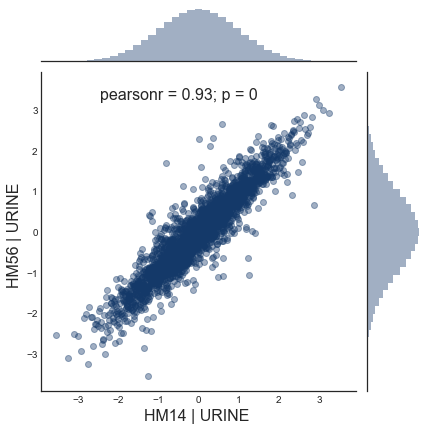

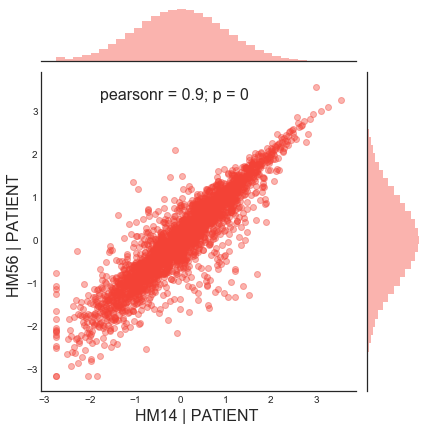

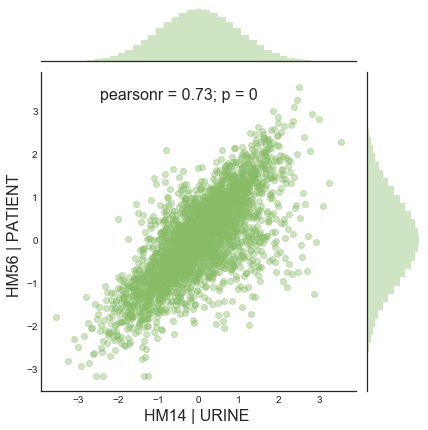

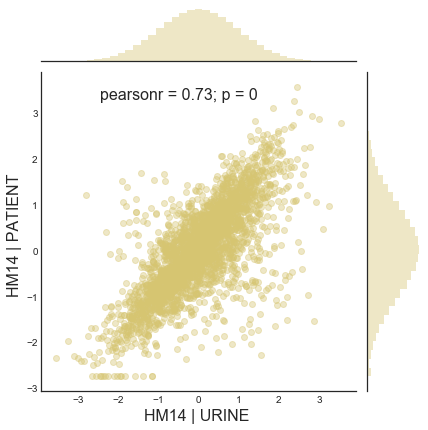

In [16]:
# Example correlation using HM14 and HM56
conditions = [("HM14_UR", "HM56_UR"), # UR vs. UR
              ("HM14_UTI", "HM56_UTI"), # UTI vs. UTI
              ("HM14_UR", "HM56_UTI"), # UR vs. unmatched UTI
              ("HM14_UR", "HM14_UTI")] # UR vs. matched UTI
FS = 16
matplotlib.rc('legend', fontsize=FS)
clrs = [col5, col1, col3, col2, col4]
for i, cond in enumerate(conditions):
    s = sns.jointplot(ntpms[cond[0]], ntpms[cond[1]], color=clrs[i], alpha=0.4);
    yl = sample_label_from_sample_name(cond[1])
    xl = sample_label_from_sample_name(cond[0])
    s.set_axis_labels(xl, yl, fontsize=FS)
    fn = os.path.join(figures_dir, "Figure_2a_{}.png".format(i+1))
    s.savefig(fn, dpi = 500, bbox_inches = "tight")

In [115]:
def generate_list(strains, conditions):
    return ["{}_{}".format(s, c) for s in strains for c in conditions]


def calc_corr(df, cmbs): # list of tuples
    crltns = []
    for cm in cmbs:
        crltns.append(df[cm[0]].corr(df[cm[1]], method='pearson'))
    return crltns

def put_correlations_into_df(crltns, label):
    d = {"sample":[label]*len(crltns), "pearson":crltns}
    return pd.DataFrame(d)

# Given a list calculate correlation between each two samples, return list of correlations
def calculate_correlation_within_group(df, group, label):
    cmbs = list(itertools.combinations(group, 2))
    crltns = calc_corr(df, cmbs)
    return put_correlations_into_df(crltns, label)
    

# Given two lists calculate corelations between all possible combinaions between the two, return list of correlations
def calculate_correlation_between_two_group(df, group1, group2, label):
    cmbs = list(itertools.product(group1, group2))
    crltns = calc_corr(df, cmbs)
    return put_correlations_into_df(crltns, label)


def plotCorr(data, filename=''):
    sns.set_style("ticks")
    plt.figure(figsize=(8,8))
    ax = sns.boxplot(x = "sample", y = "pearson", data = data, palette=[col5, col1, col3, col2, col1], 
                     width=.5, showfliers=False)
    ax = sns.swarmplot(x = "sample", y = "pearson", data = data, color = 'black', alpha = 0.4)
    ax.set_xlabel("")
    ax.set_ylabel("Pearson Correlation Coefficient", fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14)
    plt.ylim(0.5, 1)
    if filename:
        plt.savefig(filename, dpi = 500, bbox_inches="tight")
    plt.show()
    
    
def plot_correlation_for_strain_set(strain_set, fn=''):
    urine_set = generate_list(strain_set, ["UR"])
    uti_set = generate_list(strain_set, ["UTI"]) 
    matched = [("{}_UR".format(st), "{}_UTI".format(st)) for st in strain_set]

    correlation_df = pd.concat([calculate_correlation_within_group(ntpms, urine_set, ur+join+ur),
                            calculate_correlation_within_group(ntpms, uti_set, uti+join+uti),
                            calculate_correlation_between_two_group(ntpms, urine_set, uti_set, ur+join+uti),
                            put_correlations_into_df(calc_corr(ntpms, matched), ur+join+uti+":matched")])
    plotCorr(correlation_df, fn)
    return correlation_df

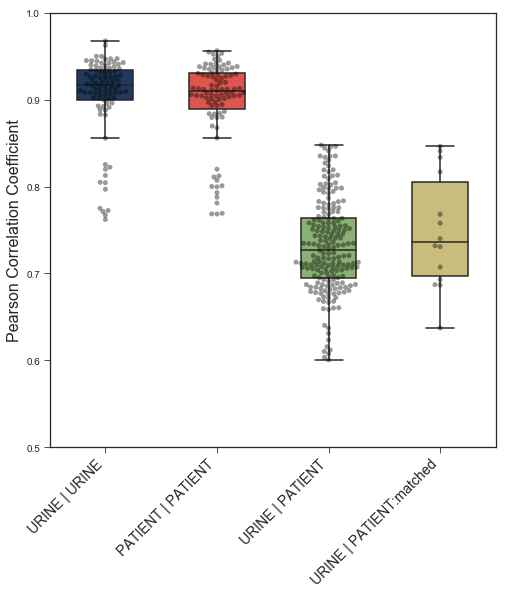

,pearson
sample,
PATIENT | PATIENT,0.910255
URINE | PATIENT,0.727561
URINE | PATIENT:matched,0.736019
URINE | URINE,0.916149


In [117]:
fn = os.path.join(figures_dir, "Figure_2b.png")
df = plot_correlation_for_strain_set(strains, fn)
df.groupby("sample").median()

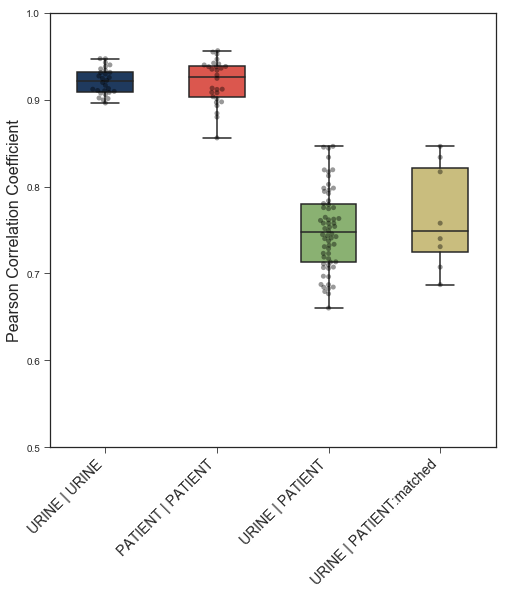

,pearson
sample,
PATIENT | PATIENT,0.910255
URINE | PATIENT,0.727561
URINE | PATIENT:matched,0.736019
URINE | URINE,0.916149


In [110]:
# Not sure I need to show this

plot_correlation_for_strain_set(over, fn='')
df.groupby("sample").median()

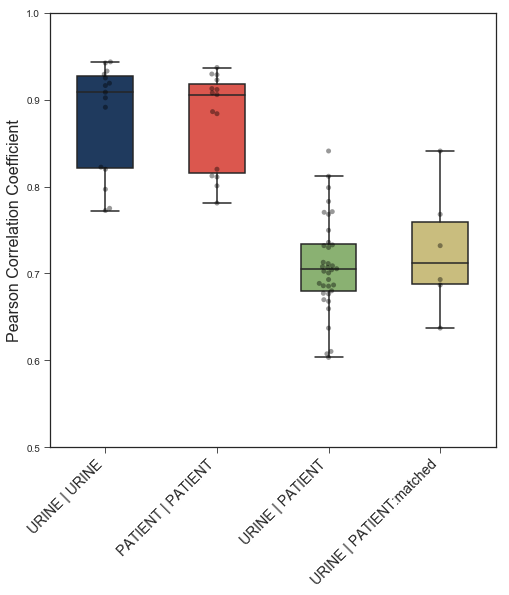

In [94]:
# both outliers are in this group

plot_correlation_for_strain_set(under, fn='')